In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import yaml
import shutil
from datetime import datetime

In [2]:
### All global variables that would be passed as arguments in a python script
input_folders = [
    "/home/nils/Downloads/WindowManagementBM_1739699044",
    "/home/nils/Downloads/WindowManagementBM_1739699063",
    "/home/nils/Downloads/WindowManagementBM_1739699082",
    "/home/nils/Downloads/WindowManagementBM_1739699101",
    "/home/nils/Downloads/WindowManagementBM_1739699120",
    "/home/nils/Downloads/WindowManagementBM_1739699140",
    "/home/nils/Downloads/WindowManagementBM_1739699159"
]
output_folder = "/home/nils/Downloads/output_plots"
statistics_csv_name = "all_statistics.csv"
pipeline_txt_name = "pipelines.txt"
cache_hits_misses_name = "cache_hits_and_misses.txt"
benchmark_config_file = "benchmark_config.yaml"
statistics_csv_path = os.path.join(output_folder, statistics_csv_name)


# Remove the output_folder and then create it again
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.mkdir(output_folder)


# Set the seaborn style
sns.set(style="whitegrid")

In [54]:
# Converts a large number to a string 
def format_si_units(number):
    # Define SI unit prefixes
    si_prefixes = ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y']

    # Handle zero as a special case
    if number == 0:
        return "0"

    # Determine the sign of the number
    sign = ''
    if number < 0:
        sign = '-'
        number = -number

    # Determine the order of magnitude
    order_of_magnitude = 0
    while number >= 1000 and order_of_magnitude < len(si_prefixes) - 1:
        number /= 1000.0
        order_of_magnitude += 1

    # Format the number to one decimal place and append the SI prefix
    formatted_number = f"{number:.3f}{si_prefixes[order_of_magnitude]}"

    # Add the sign back to the formatted number
    return sign + formatted_number


# Converting pipelines.txt to a dict of pipeline id to a title
def extract_pipeline_data(input_path):
    with open(input_path, 'r') as input_file:
        input_text = input_file.read()

    pipeline_dict = {}
    # Split the input text by the delimiter
    pipeline_sections = input_text.split("############################################")
    physical_pattern = re.compile(r"\bPhysical\w+")

    for section in pipeline_sections:
        # Find the pipeline ID in the section
        pipeline_match = re.search(r"Pipeline:\s*(\d+)", section)
        if pipeline_match:
            pipeline_id = int(pipeline_match.group(1))
            if pipeline_id not in pipeline_dict:
                pipeline_dict[pipeline_id] = []
            
            # Find all words starting with 'Physical' in the section
            physical_matches = physical_pattern.findall(section)
            cleaned_matches = [match.replace("Physical", "").replace("Operator", "").replace("Stream", "") for match in physical_matches]
            pipeline_dict[pipeline_id].extend(cleaned_matches)
    
    # Concatenate multiple values with "_"
    return {key: "_".join(values) for key, values in pipeline_dict.items()}

# Converting a cache hits and misses file to two dictionaries
def parse_lines_to_dataframe(file):
    with open(file, 'r') as input_file:
        lines = input_file.readlines()
        
    # Initialize dictionaries to hold the hits and misses data
    hits_data = {}
    misses_data = {}

    # Regular expression to extract information
    pattern = re.compile(r'Hits: (\d+) Misses: (\d+) for worker thread (\d+)(?: and join build side (\w+))?')

    for line in lines:
        match = pattern.search(line)
        if match:
            hits, misses, thread_id, build_side = match.groups()
            # Determine the column name
            if build_side:
                column_name = f'worker_{thread_id}_{build_side}'
            else:
                column_name = f'worker_{thread_id}'

            # Store the hits and misses in the dictionaries with prefixes
            hits_column_name = f'hits_{column_name}'
            misses_column_name = f'misses_{column_name}'

            if hits_column_name not in hits_data:
                hits_data[hits_column_name] = []
                misses_data[misses_column_name] = []

            hits_data[hits_column_name] = (int(hits))
            misses_data[misses_column_name] = (int(misses))

    # Adding a total hits and misses column
    hits_data["hits_total"] = sum(hit for hit in hits_dict.values())
    hits_data["misses_total"] = sum(miss for miss in misses_dict.values())
    
    return hits_data, misses_data

In [33]:
# Gathering all cache statistic files across all folders
def load_cache_statistics():
    cache_statistic_files = [(input_folder_name, os.path.join(input_folder_name, f)) for input_folder_name in input_folders for f in os.listdir(input_folder_name) if cache_hits_misses_name in f]
    cache_stats_combined_df = pd.DataFrame()
    no_cache_stats_files = len(cache_stats_combined_df)
    cnt_rows = 0
    for idx, [input_folder, cache_stat_file] in enumerate(cache_statistic_files):
        # Reading the benchmark configs and the hits and misses
        with open(os.path.join(input_folder, benchmark_config_file), 'r') as file:
            benchmark_config_yaml = yaml.safe_load(file)
    
        (hits_dict, misses_dict) = parse_lines_to_dataframe(cache_stat_file)
        
        # Combine the dictionaries
        combined_dict = {**hits_dict, **misses_dict, **benchmark_config_yaml.copy()}
        new_row_df = pd.DataFrame([combined_dict])
        cache_stats_combined_df = pd.concat([cache_stats_combined_df, new_row_df], ignore_index=True)

    return cache_stats_combined_df
    
# Drop the specified columns
#columns_to_drop = ['hits_worker_0_Right', 'misses_worker_0_Left', 'hits_total']
#cache_stats_combined_df = drop_columns(cache_stats_combined_df, columns_to_drop)
cache_stats_combined_df = load_cache_statistics()
cache_stats_combined_df

,hits_worker_0,hits_worker_1,hits_worker_2,hits_worker_3,hits_total,misses_total,misses_worker_0,misses_worker_1,misses_worker_2,misses_worker_3,...,buffers_per_worker,lock_slice_cache,nautilus_backend,numberOfEntriesSliceCache,number_of_worker_threads,query,slice_cache_type,slice_store_type,task_queue_size,timestamp_increment
0,7643237,4485790,2993901,2300002,121340140,3755,1640,1061,774,599,...,12800,True,COMPILER,1,4,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,LRU,MAP,100000,1
1,3589067,6006967,1220455,6501488,121340140,3755,1054,1544,347,1733,...,12800,False,COMPILER,1,4,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,LRU,MAP,100000,1
2,15203,9218848,7953470,167737,121340140,3755,105,1735,1592,186,...,12800,True,COMPILER,1,4,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,FIFO,MAP,100000,1
3,6154590,4218866,3605547,3284363,121340140,3755,1413,873,1147,1110,...,12800,False,COMPILER,1,4,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,FIFO,MAP,100000,1
4,228006,7329385,3428718,6237289,121340140,3755,281,1700,1361,1691,...,12800,True,COMPILER,1,4,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,SECOND_CHANCE,MAP,100000,1
5,4800935,4373840,1267691,6923289,121340140,3755,1131,1017,435,1172,...,12800,False,COMPILER,1,4,SELECT MIN(value) FROM tcp_source WINDOW SLIDI...,SECOND_CHANCE,MAP,100000,1


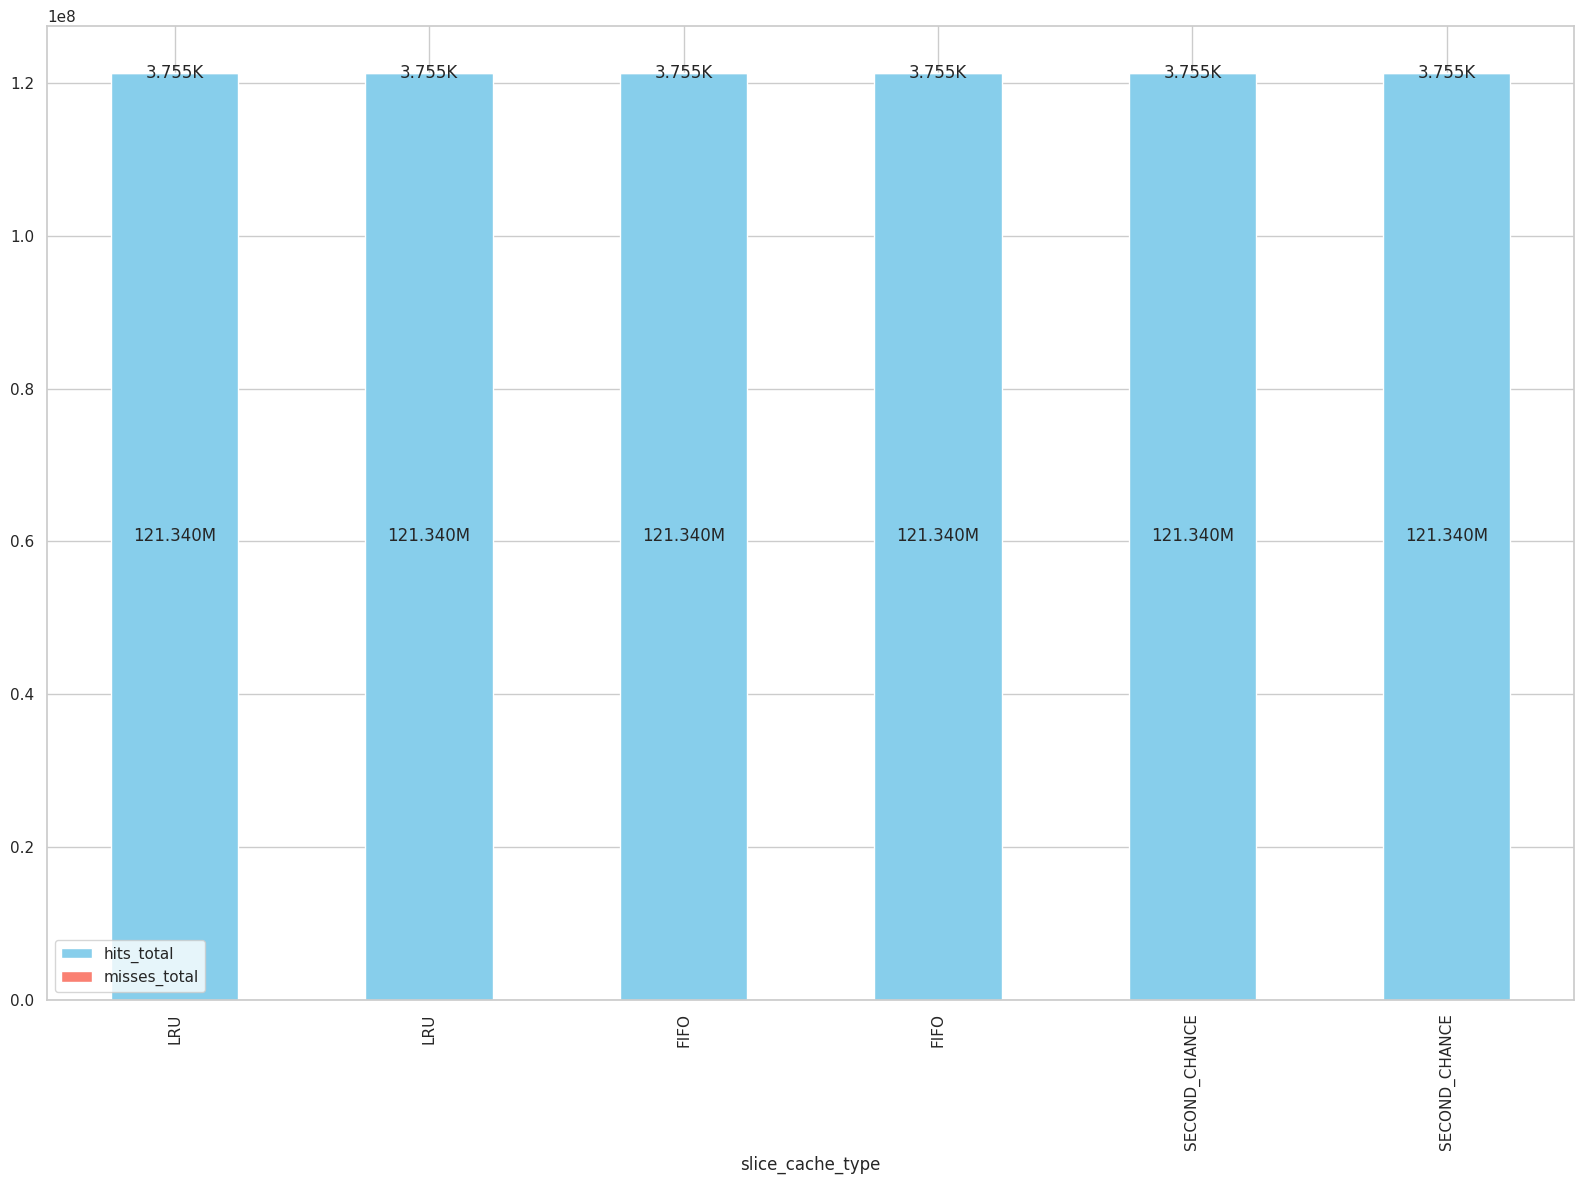

In [56]:
# Plotting the number of hits and misses per cache type
cache_stats_combined_df = load_cache_statistics()
interesting_param = "number_of_worker_threads"
x_param="slice_cache_type"
hue = "numberOfEntriesSliceCache"
y_params = ["hit_percentage", "hits_total", "misses_total"]
cache_stats_combined_df["hit_percentage"] = cache_stats_combined_df["hits_total"] / (cache_stats_combined_df["hits_total"] + 
                                                                                     cache_stats_combined_df["misses_total"])

# Create a subplot grid.
unique_params = cache_stats_combined_df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(1, n_params, figsize=(16, 12), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = cache_stats_combined_df[cache_stats_combined_df[interesting_param] == param]
    plot_data = cache_stats_combined_df[["hits_total", "misses_total"]]
    plot_data.set_index(subset[x_param], inplace=True)
    ax = axes[0][idx]
    plot_data.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'salmon']) #, logy=True)
    #ax.set_ylim(bottom=0.1)
    
    
    # Annotate the bars with hits and misses values
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        height_str = format_si_units(height)
        ax.text(x + width / 2, y + height / 2, f'{height_str}', horizontalalignment='center', verticalalignment='center')


plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()

In [4]:
# Converting query engine statistics to statistics csv
pattern_worker_file = r"^worker_\d+\.txt$"
pattern_task_details = (r"(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+).*?"
       r"Task (?P<task_id>\d+) for Pipeline (?P<pipeline>\d+).*?"
       r"(?P<action>Started|Completed)(?:\. Number of Tuples: (?P<num_tuples>\d+))?")

# Gathering all statistic files across all folders
statistic_files = [(input_folder_name, os.path.join(input_folder_name, f)) for input_folder_name in input_folders for f in os.listdir(input_folder_name) if re.match(pattern_worker_file, f)]
combined_df = pd.DataFrame()
no_statistics_files = len(statistic_files)
cnt_rows = 0
for idx, [input_folder, stat_file] in enumerate(statistic_files):
    print(f"Processing {stat_file} [{idx+1}/{no_statistics_files}]")
    with open(stat_file, 'r') as file:
        log_text = file.read()

    with open(os.path.join(input_folder, benchmark_config_file), 'r') as file:
        benchmark_config_yaml = yaml.safe_load(file)
    
    records = []
    tasks = {}
    for match in re.finditer(pattern_task_details, log_text):
        timestamp = pd.to_datetime(match.group("timestamp"), format="%Y-%m-%d %H:%M:%S.%f")
        task_id = int(match.group("task_id"))
        action = match.group("action")
        num_tuples = int(match.group("num_tuples")) if match.group("num_tuples") else None
        pipeline_id = int(match.group("pipeline")) if match.group("pipeline") else None
    
        if action == "Started":
            tasks[task_id] = {"start_time": timestamp, "num_tuples": num_tuples}
        elif action == "Completed" and task_id in tasks:
            task_info = tasks[task_id]
            start_time = task_info["start_time"]
            duration = (timestamp - start_time).total_seconds()
            throughput = task_info["num_tuples"] / duration if duration > 0 else -1
            new_record = benchmark_config_yaml.copy()
            
            new_record['query'] = new_record['query'].replace(";", "")
            new_record.update({
                "task_id": task_id,
                "start_time": start_time,
                "end_time": timestamp,
                "duration": duration, # Seconds
                "num_tuples": task_info["num_tuples"],
                "throughput": throughput, # tup/s
                "pipeline_id": pipeline_id
            })
            
            records.append(new_record)
    
    # Create DataFrame and 
    df = pd.DataFrame(records)

    # Normalize all timestamps to the minimal start timestamp of any task
    min_start_time = df['start_time'].min()
    df['start_time_normalized'] = df['start_time'] - min_start_time
    df['end_time_normalized'] = df['end_time'] - min_start_time

    # Sorting the dataframe
    df = df.sort_values(by='task_id').reset_index(drop=True)

    # Write the created dataframe to the csv file
    df.to_csv(os.path.join(input_folder, stat_file + ".csv"), index=False)
    
    # Adding this dataframe to the global one
    cnt_rows += len(df)
    print(f"Adding {len(df)} rows to combined dataframe with an expected total no. rows of {cnt_rows}")
    combined_df = pd.concat([combined_df, df], ignore_index=True)



# Writing the combined dataframe to a csv file
combined_df.to_csv(statistics_csv_path, index=False)
print(f"Done with combining all query engine statistics to {statistics_csv_path}! No. rows: {len(combined_df)}")
combined_df.columns

Processing /home/nils/Downloads/WindowManagementBM_1739699044/worker_0.txt [1/28]


KeyboardInterrupt: 

In [ ]:
# Reading the combined data into dataframe named df and printing a little summary of the data frame
df = pd.read_csv(statistics_csv_path)
    
# General info
print("### DataFrame Summary ###\n")
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
print("Columns and Data Types:")
print(df.dtypes, "\n")

# Number of unique values per column
print("Number of Unique Values per Column:")
print(df.nunique(), "\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum(), "\n")

# Descriptive statistics for numeric columns
print("Descriptive Statistics (Numeric Columns):")
print(df.describe().T, "\n")

# Display a sample of rows
print("Sample Rows:")
display(df.head(5))

In [ ]:
# Plotting the total no. tuples, no. tasks, total duration per no. worker threads

# Aggregate the data by number_of_worker_threads
aggregated_data = df.groupby(["number_of_worker_threads", "buffer_size_in_bytes"]).agg(
    total_tuples=('num_tuples', 'sum'),
    total_tasks=('task_id', 'count'),
    total_duration=('duration', 'sum')
).reset_index()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot total number of tuples
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tuples",
    palette="viridis",
    hue="buffer_size_in_bytes",
    ax=axes[0]
)
axes[0].set_title("Total Number of Tuples per Worker Threads")
axes[0].set_xlabel("Number of Worker Threads")
axes[0].set_ylabel("Total Tuples")

# Plot total number of tasks
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_tasks",
    palette="colorblind",
    hue="buffer_size_in_bytes",
    ax=axes[1]
)
axes[1].set_title("Total Number of Tasks per Worker Threads")
axes[1].set_xlabel("Number of Worker Threads")
axes[1].set_ylabel("Total Tasks")

# Plot total duration
sns.barplot(
    data=aggregated_data,
    x="number_of_worker_threads",
    y="total_duration",
    palette="colorblind",
    hue="buffer_size_in_bytes",
    ax=axes[2]
)
axes[2].set_title("Total Duration per Worker Threads")
axes[2].set_xlabel("Number of Worker Threads")
axes[2].set_ylabel("Total Duration (ms)")

# Adjust layout
plt.tight_layout()
plt.show()
plt.close(fig)


In [ ]:
df = pd.read_csv(statistics_csv_path)
group = df.groupby('number_of_worker_threads')

group.size()

In [ ]:
# Plotting the throughput and duration for each pipeline in intervals
# Only do this for buffer_size_in_bytes == 8196
df = pd.read_csv(statistics_csv_path)
df = df[df['buffer_size_in_bytes'] == 8196]

# Normalize the timestamps to timedelta and milliseconds
df['start_time_normalized'] = pd.to_timedelta(df['start_time_normalized'])
df['start_time_normalized_ms'] = df['start_time_normalized'].dt.total_seconds() * 1000
df['end_time_normalized'] = pd.to_timedelta(df['end_time_normalized'])

# Create intervals
interval_size_in_ms = 500
intervals = pd.cut(df['start_time_normalized_ms'], bins=range(0, int(df['start_time_normalized_ms'].max()) + interval_size_in_ms, interval_size_in_ms), right=False)
df['interval'] = intervals
df['interval'] = df['interval'].apply(lambda x: x.left)

# Group by pipeline_id and create a plot for each group
interesting_pipeline_ids = df["pipeline_id"].unique()
df = df[df['pipeline_id'].isin(interesting_pipeline_ids)]
for pipeline_id, group in df.groupby("pipeline_id"):
    # Select only the necessary columns for computation
    group = group[['interval', 'number_of_worker_threads', 'throughput', 'duration', 'num_tuples']]
    
    sum_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=True).agg({
        'num_tuples': 'sum',
        'duration': 'sum',
    })
    # Calculate throughput as sum(num_tuples) / sum(duration)
    sum_group['throughput'] = sum_group['num_tuples'] / sum_group['duration']
    print(sum_group)


    # Calculate the average duration
    avg_group = group.groupby(['interval', 'number_of_worker_threads'], as_index=False)['duration'].mean()

    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(16, 10))
    
    # Plot throughput vs interval
    sns.barplot(
        data=sum_group,
        x="interval",
        y="throughput",
        hue="number_of_worker_threads",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Interval ({interval_size_in_ms}ms)")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Throughput [tup/s]")

    # Plot duration vs interval
    sns.barplot(
        data=avg_group,
        x="interval",
        y="duration",
        hue="number_of_worker_threads",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Interval ({interval_size_in_ms}ms)")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Duration (ms)")

    # Plot no. tuples vs interval
    sns.barplot(
        data=sum_group,
        x="interval",
        y="num_tuples",
        hue="number_of_worker_threads",
        ax=axes[2]
    )
    axes[2].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Interval ({interval_size_in_ms}ms)")
    axes[2].set_xlabel("Interval")
    axes[2].set_ylabel("Num Tuples")

    # Adjust layout and save the figure
    plt.tight_layout()
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}_intervals_{interval_size_in_ms}ms.png")
    plt.savefig(figure_path)
    plt.close(fig)  # Close the figure to free memory



In [ ]:
#Plotting duration and throughput as a lineplot over the start_time_normalized
# Unique pipeline IDs
unique_pipeline_ids = df['pipeline_id'].unique()

# Generate one plot per pipeline
for pipeline_id in unique_pipeline_ids:
    # Filter data for the current pipeline_id
    pipeline_data = df[df['pipeline_id'] == pipeline_id]
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot throughput
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='throughput',
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[0]
    )
    axes[0].set_title(f"Pipeline ID {pipeline_id}: Throughput vs Time")
    axes[0].set_xlabel("Start Time")
    axes[0].set_ylabel("Throughput")
    
    # Plot duration
    sns.lineplot(
        data=pipeline_data,
        x='start_time_normalized',
        y='duration',
        hue='buffer_size_in_bytes',
        marker="o",
        ax=axes[1]
    )
    axes[1].set_title(f"Pipeline ID {pipeline_id}: Duration vs Time")
    axes[1].set_xlabel("Start Time")
    axes[1].set_ylabel("Duration")
    
    # Adjust layout for readability
    plt.tight_layout()
    
    # Save the figure
    figure_path = os.path.join(output_folder, f"pipeline_{pipeline_id}.png")
    plt.savefig(figure_path)
    plt.close(fig)  # Close the figure to save memory

In [ ]:
# Plotting the number of hits and misses per cache type
cache_stats_combined_df = load_cache_statistics()
interesting_param = "number_of_worker_threads"
x_param="slice_cache_type"
hue = "numberOfEntriesSliceCache"
y_params = ["hit_percentage", "hits_total", "misses_total"]
cache_stats_combined_df["hit_percentage"] = cache_stats_combined_df["hits_total"] / (cache_stats_combined_df["hits_total"] + 
                                                                                     cache_stats_combined_df["misses_total"])

# Create a subplot grid.
unique_params = cache_stats_combined_df[interesting_param].unique()
n_params = len(unique_params)
fig, axes = plt.subplots(3, n_params, figsize=(16, 12), squeeze=False, sharey='row')
for idx, param in enumerate(unique_params):
    subset = cache_stats_combined_df[cache_stats_combined_df[interesting_param] == param]

    ax = axes[0][idx]
    sns.barplot(x=x_param, y=y_params[0], hue=hue, data=subset, ax=ax, palette="colorblind")
    ax.set_title(f"Cache Hit Percentage for {param} Threads")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"#Hits")
    ax.set_ylim(bottom=0)

    ax = axes[1][idx]
    sns.barplot(x=x_param, y=y_params[1], hue=hue, data=subset, ax=ax, palette="colorblind")
    ax.set_title(f"Cache Hits for {param} Threads")
    ax.set_xlabel(x_param)
    ax.set_ylabel(f"#Hits")
    ax.set_ylim(bottom=0)

    ax = axes[2][idx]
    sns.barplot(x=x_param, y=y_params[2], hue=hue, data=subset, ax=ax, palette="colorblind")
    ax.set_title(f"Cache Misses for {param} Threads")
    ax.set_xlabel(param)
    ax.set_ylabel(f"#Misses")
    #ax.set_yscale('log')
    ax.set_ylim(bottom=0)


plt.tight_layout()
#plt.savefig(os.path.join(output_folder_plots, f"plots.png"))
plt.show()
plt.close()